# DSH-II Use Case Analysis #
This notebook can be used as an outline for your use case analysis. All the relevant sections are there. 
1. Data Loading
2. Data Exploration
3. Feature Engineering
4. Train-Test Splitting
5. Model Training
6. Model Evaluation

The use cases may have missing data or other exploratory transformations that you need to perform. Try to focus on going through the whole workflow. This way you can get a feel of what it is like to work on a data science project. If your model does not perform as expected, don't fret too much about it. Make sure you have performed the steps as you have learned and then discuss the issues of your model in your presentation, where you think about why it could be performing this way and what might be improved.

Tips:
- When writing your code, add as many fields as you like or need. 
- Feel free to check in with previous assignments if you don't remember how certain methods worked.
- Remember that you will also be graded on your code, so make sure to annotate your steps in a similar way as you have seen in the assignments.
***

## 1. Data Loading ##
The data has been processed by us for you, so you cannot find the data as is.

Data Source: https://www.kaggle.com/openfoodfacts/world-food-facts

There are 9 variables and 1 target (calories). The variables are pretty self explanatory, but a more elaborate description can be found in the data source.

- Food
- Measure
- Grams
- Calories
- Protein
- Fat
- Sat.Fat
- Fiber
- Carbs
- Category

In [1]:
# Put any package/library imports here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data here
file = 'macronutrients.csv'

# Store the data into a pandas dataframe
with open(file, 'r') as f:
    df = pd.read_csv(f)

In [3]:
# Lets take a look at some points our dataset
df.head(5)


,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category
0,Cows' milk,1 qt.,976,660.0,32,40,36.0,0.0,48.0,Dairy products
1,Milk skim,1 qt.,984,360.0,36,0,0.0,0.0,52.0,Dairy products
2,Buttermilk,1 cup,246,127.0,9,5,4.0,0.0,13.0,Dairy products
3,Evaporated undiluted,1 cup,252,345.0,16,20,18.0,0.0,24.0,Dairy products
4,Fortified milk,6 cups,1419,1373.0,89,42,23.0,1.4,119.0,Dairy products


From this head of the dataset it can be seen that there are a lot of different numbers of grams in which a food product is displayed. This is because the serving size of the food products differs. Because of these differences, it can not be told what the relative values are of calories and the macronutrients for each products. Therefore, feature engineering should be performed to make sure that every datapoint is using an universal amount of grams. A 100 gram standard could be used, since this is commonly used when describing food items. 

This should be fixed before performing the other steps, otherwise the visualisation of the data will not make much sense. 


# Some preliminary feature engeneering

In [4]:
# We want to set all the datapoints to a 100 gram scale.
# We create a new column containing the ratios.

new_df1 = df.copy()

print(new_df1.head(1))

new_df1['Ratios'] = 100 / df['Grams']

new_df1['Grams'] = df['Grams'] * new_df1['Ratios']
new_df1['Calories'] = df['Calories'] * new_df1['Ratios']
new_df1['Protein'] = df['Protein'] * new_df1['Ratios']
new_df1['Fat'] = df['Fat'] * new_df1['Ratios']
new_df1['Sat.Fat'] = df['Sat.Fat'] * new_df1['Ratios']
new_df1['Fiber'] = df['Fiber'] * new_df1['Ratios']
new_df1['Carbs'] = df['Carbs'] * new_df1['Ratios']

new_df1.head(1)
new_df1 = new_df1.round(decimals = 5)

df = new_df1


         Food Measure  Grams  Calories  Protein  Fat  Sat.Fat  Fiber  Carbs  \
0  Cows' milk   1 qt.    976     660.0       32   40     36.0    0.0   48.0   

         Category  
0  Dairy products  


## 2. Data Exploration ##

### 2.1 Variable Identification ###

In [5]:
# Taking a look at type of our different features.
df.dtypes


Food         object
Measure      object
Grams       float64
Calories    float64
Protein     float64
Fat         float64
Sat.Fat     float64
Fiber       float64
Carbs       float64
Category     object
Ratios      float64
dtype: object

All the macronutrients are floats. The category, food and measure columns contain objects. The category column, which contains the different food types, should be looked more into if this variable would be used in the predictions. When the attribute consists of objects, the regression model can not use them. Therefore, the attribute should be changed to numerical values. 

### 2.2 Univariate Analysis ###

In [6]:
# Taking a look at some descriptive statistics of our dataset.

df.describe()

,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Ratios
count,335.0,334.000000,335.000000,335.000000,333.000000,334.000000,335.000000,335.000000
mean,100.0,203.764775,7.912350,11.008312,7.399538,1.699178,22.149890,1.445234
std,0.0,190.519894,12.620144,21.197611,15.930566,10.038926,26.729858,1.568533
min,100.0,0.000000,-1.666670,0.000000,0.000000,0.000000,0.000000,0.070470
25%,100.0,51.306505,0.587225,0.000000,0.000000,0.000000,3.540100,0.500000
50%,100.0,140.454545,3.174600,1.176470,0.000000,0.200000,11.157020,0.925930
75%,100.0,304.471457,10.619680,11.066435,7.894740,0.857140,30.000000,1.666670
max,100.0,901.818180,101.785710,102.678570,103.571430,104.464290,128.000000,9.090910


There are 335 datapoints in the set.
One datapoint has a missing value for the calories column.
There are also missing values for sat.fat and fiber.
These missing values are dealt with later on. 


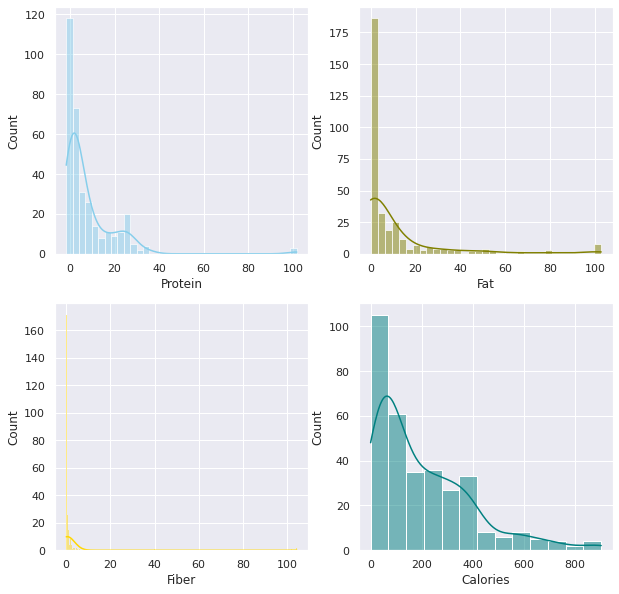

In [7]:
# Let's take a look at how some of the macronutriënts in our dataset are distributed.
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=df, x="Protein", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="Fat", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="Fiber", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="Calories", kde=True, color="teal", ax=axs[1, 1])

plt.show()



It can be seen that there are probably 1 or 2 outliers in the dataset. These outliers are kept into consideration for later on. 

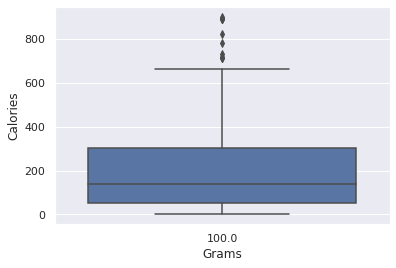

In [8]:
# Taking a look at how the datapoints are distributed in a boxplot of calories by grams.
sns.boxplot(data=df, x = "Grams", y = "Calories")
plt.show()

The boxplot shows a few outliers when it comes to calories per gram of product. This is to be expected, it could for example be a product like Olive Oil which has a high caloric value. However, since the aim of the model is to predict all food labels we should take these "Outliers" into consideration, and still use them for model training later on. Food products such as Olive Oil should also be predicted in the model for a real-world application. 

### 2.3 Bi-variate Analysis ###

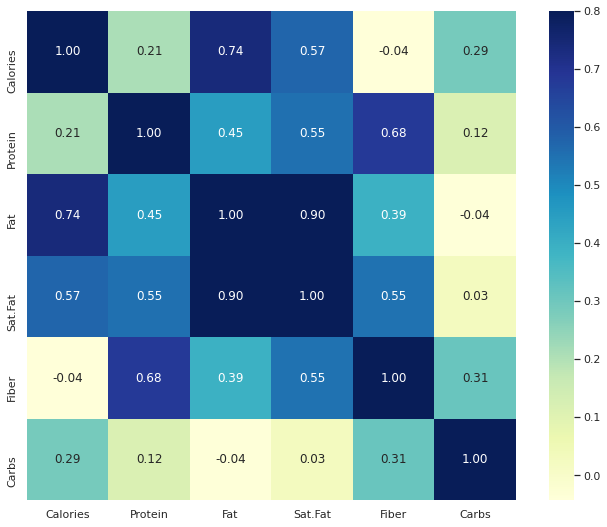

<AxesSubplot:>

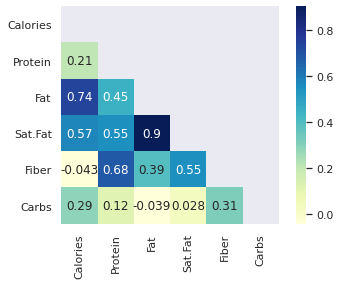

In [9]:
# define all the variables that are continuous, for later selection
columns = ['Calories','Protein','Fat','Sat.Fat', 'Fiber', 'Carbs']

# Plotting a heatmap
corrmat = df[columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, fmt='.2f', annot=True, cmap = "YlGnBu");
plt.show()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

# Highlighting a part of the heatmap
sns.heatmap(corrmat, mask=mask, square=True, annot=True, cmap = "YlGnBu")

Some things that can be read from the graph are:
- Fat is the best predictor of calories, which was expected follwoing the domain knowledge. 
- Fiber is a really poor predictor, which is also not very surprising. Because fiber does not contribute much to the calorie amount. However it could be of impact when we are looking for Net metabolizable Energy. So we will use it.
- It can also be seen that Saturated fat is an excellent predictor of amount of fat, which is also not a surprise since saturated fat is part of the total fat content.

### 2.4 Missing values treatment ###

In [10]:
# We should drop the row that has a missing value for fiber and sat.fat, since we do not know the contents of this product.
df.drop(df[df['Fiber'].isnull()].index, inplace=True)
display(df[df.isnull().any(axis=1)])

df.drop(df[df['Sat.Fat'].isnull()].index, inplace=True)
display(df[df.isnull().any(axis=1)])

# We should also drop the row with missing values for calories, since it cannot be use for predictions.
display(df[df.isnull().any(axis=1)])
df.drop(df[df['Calories'].isnull()].index, inplace=True)

,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category,Ratios
42,Salt pork,2 oz.,100.0,783.33333,5.00000,91.66667,NaN,0.0,0.00000,Meat Poultry,1.66667
100,Beetroots,1 cup,100.0,0.60606,7.27273,0.00000,NaN,0.0,0.48485,Vegetables A-E,0.60606
134,Frozen peas,1 cup,100.0,NaN,5.00000,0.00000,0.0,1.8,12.00000,Vegetables R-Z,1.00000


,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category,Ratios
134,Frozen peas,1 cup,100.0,NaN,5.0,0.0,0.0,1.8,12.0,Vegetables R-Z,1.0


,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category,Ratios
134,Frozen peas,1 cup,100.0,NaN,5.0,0.0,0.0,1.8,12.0,Vegetables R-Z,1.0


### 2.5 Outlier treatment ###

Since the aim is to create a model that is able to predict the NME values for all products,  all datapoints should be taken into consideration. Therefore outlier treatment is not performed, since outliers cannot be pinpointed in the dataset.

## 3. Feature Engineering ##

In [11]:
# We create dummy variables for the different categories of food products.

dummy_df = pd.get_dummies(df["Category"], prefix='Category_', drop_first=False)

# Merge the original dataframe with the encoded variables
df = pd.concat([df, dummy_df], axis=1)

# Drop the original columns which we won't use
df.drop(columns=['Category'], inplace=True)

df.drop(columns=['Measure'], inplace=True)

df.drop(columns=['Food'], inplace=True)

In [12]:
# Making new the new fruits and vegatables category columns.
# We want to store them in one category, instead of them being split up in seperate pieces based on the alphabet.

new_df = df

new_df["Category__Fruits"]= (new_df["Category__Fruits A-F"] + new_df["Category__Fruits G-P"] + 
                             new_df["Category__Fruits R-Z"])

new_df["Category__Vegetables"]= (new_df["Category__Vegetables A-E"] + 
                                 new_df["Category__Vegetables F-P"] + new_df["Category__Vegetables R-Z"])

In [13]:
# Adding our new fruit and vegetable columns
df["Category__Fruits"] = new_df["Category__Fruits"]
df["Category__Vegetables"] = new_df["Category__Vegetables"]

#Also dropping the old fruit category columns
df.drop(columns=['Category__Fruits A-F','Category__Fruits G-P','Category__Fruits R-Z',"Category__Vegetables A-E","Category__Vegetables F-P","Category__Vegetables R-Z"], inplace=True)

display(df.head(5))

,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Ratios,Category__Breads cereals fastfoodgrains,Category__Dairy products,Category__Desserts sweets,Category__DrinksAlcohol Beverages,Category__Fats Oils Shortenings,Category__Fish Seafood,Category__Jams Jellies,Category__Meat Poultry,Category__Seeds and Nuts,Category__Soups,Category__Fruits,Category__Vegetables
0,100.0,67.62295,3.27869,4.09836,3.68852,0.00000,4.91803,0.10246,0,1,0,0,0,0,0,0,0,0,0,0
1,100.0,36.58537,3.65854,0.00000,0.00000,0.00000,5.28455,0.10163,0,1,0,0,0,0,0,0,0,0,0,0
2,100.0,51.62602,3.65854,2.03252,1.62602,0.00000,5.28455,0.40650,0,1,0,0,0,0,0,0,0,0,0,0
3,100.0,136.90476,6.34921,7.93651,7.14286,0.00000,9.52381,0.39683,0,1,0,0,0,0,0,0,0,0,0,0
4,100.0,96.75828,6.27202,2.95983,1.62086,0.09866,8.38619,0.07047,0,1,0,0,0,0,0,0,0,0,0,0


Some more feature engeneering that could be done is for example creating a new feature containing the ratio of saturated fat vs unsaturated fat. When creating such a ratio, the attribution of saturated and unsaturated fat to the caloric value can be determined. 

## 4. Train-Test Splitting ##

In [14]:
# Split the data
split_ratio = 0.2 # Split ratio of 0.2 since our dataset is relatively smalle we want to use a substantial amount for training.
y = df['Calories'] # define the target variable (dependent variable) as y
X = df.drop(columns=['Calories','Ratios']) # Define the features as X

# Defining the variables, using a random state to ensure that our model scores will be consistent.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state = 42)

## 5. Model Training and evaluation ##



This is the result of Random tree forest
RMSE of the train set: 19.74
RMSE of the test set: 44.86
Training score: 0.99
Test score: 0.94


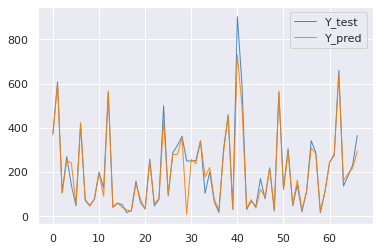


This is the result of Knn
RMSE of the train set: 44.86
RMSE of the test set: 44.36
Training score: 0.94
Test score: 0.94


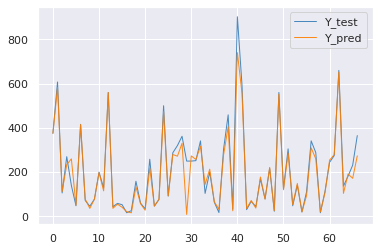


This is the result of SVM
RMSE of the train set: 56.09
RMSE of the test set: 38.78
Training score: 0.91
Test score: 0.96


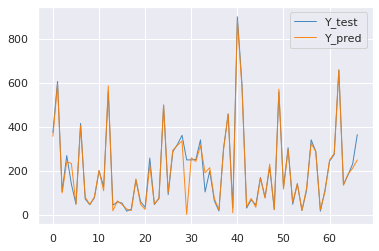

In [15]:
### Making predictions using train-test-split

# Defining different supervised learning algoryritms.
# They all ensable a learning method for regression

tree = RandomForestRegressor(n_estimators=100,max_depth = 8)
knn = KNeighborsRegressor(n_neighbors= 6)
svm = SVR(kernel='linear')


# Using a for loop to fit, make predictions, score and plot different models.
for model in [tree, knn,svm]:
    prediction = []
    model.fit(X_train,y_train)
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    model.prediction = prediction_test
    
    if model == tree:
        prediction_tree = prediction_test
        print("\nThis is the result of Random tree forest")        
    elif model == knn:
        prediction_knn = prediction_test
        print("\nThis is the result of Knn")
    elif model == svm:
        prediction_svm = prediction_test
        print("\nThis is the result of SVM")
    
# Printing the different scores
    print("RMSE of the train set: {:.2f}".format(math.sqrt(mean_squared_error(y_train,prediction_train))))
    print("RMSE of the test set: {:.2f}".format(math.sqrt(mean_squared_error(y_test,prediction_test))))
    print("Training score: {:.2f}".format(model.score(X_train, y_train)))
    print("Test score: {:.2f}".format(model.score(X_test, y_test)))
    
#making predictions
    y_pred = model.predict(X_test)

# We create the x data to be able to plot a line using only y data
    x_data = [i for i in range(len(y_test))]

# Define a color palette to use
    palette = plt.get_cmap('Set1')

# For each dataset make a line
    plt.plot(x_data, y_test, marker='', color=palette(1), linewidth=1, alpha=0.9, label="Y_test")
    plt.plot(x_data, y_pred, marker='', color=palette(4), linewidth=1, alpha=0.9, label="Y_pred")

# show a legend
    plt.legend()

# show the graphs
    plt.show()

It can be told that the random forest is overfitting to the training set since the score for the training set is higher than the score of the test set. Also, the RMSE is lower for the training set meaning that there is smaller mean squared error. This overfitting could be improved by trying different parameters.

The KNN shows the most promising predictions, with a high model score and a low RMSE.

SVM also shows good predictions, but it shows lesser results on the RMSE. Therefore KNN is probably a better fit.

In [16]:
# We can see that all models predict point 29 wrong, lets try and find out why that is
X_test.iloc[29]

Grams                                      100.0
Protein                                      0.0
Fat                                          0.0
Sat.Fat                                      0.0
Fiber                                        0.0
Carbs                                        0.0
Category__Breads cereals fastfoodgrains      0.0
Category__Dairy products                     0.0
Category__Desserts sweets                    0.0
Category__DrinksAlcohol Beverages            1.0
Category__Fats Oils Shortenings              0.0
Category__Fish Seafood                       0.0
Category__Jams Jellies                       0.0
Category__Meat Poultry                       0.0
Category__Seeds and Nuts                     0.0
Category__Soups                              0.0
Category__Fruits                             0.0
Category__Vegetables                         0.0
Name: 324, dtype: float64

Datapoint 29 has all 0 values for the different macronutrients.
It is probably gin, which only contains alcohol. Alcohol is weirdly enough not one of the macronutrients in the dataset.
This causes the model to not be able to make predictions.

It can be seen that the model is rarely underpredicting when it is wrong. Just overpredicting.
This might be because Alcohol macronutrient is missing in the dataset, but it does count up to the total caloric value.

This could be dealed with in the outlier treatment by adding a column containing the alcohol content of product. But since there are only three alcohol containing products in the current dataset, it is not neccesary for now. It should be done in further research. 

# Using cross validationt to score the model

Instead of train-test splitting we could also apply cross validaton. This can be usefull since our dataset is quite small.

In [17]:
## Predictions using Cross validation

tree = RandomForestRegressor(n_estimators=200,max_depth = 7, )
knn = KNeighborsRegressor(n_neighbors= 3)
svm = SVR(kernel='linear')


for model in [tree, knn,svm]:
    prediction = []
    model.fit(X,y)
    prediction = model.predict(X)

    
    if model == tree:
        prediction_tree = prediction
        print("\nThis is the result of Random forest")        
    elif model == knn:
        prediction_knn = prediction
        print("\nThis is the result of KNN")
    elif model == svm:
        prediction_svm = prediction
        print("\nThis is the result of SVM")
# Showing the model scores and standard deviation using cross validation
    print("Score: {:.2f}".format(np.mean(cross_val_score(model, X, y, cv=10, scoring='r2'))))

    print("Standard deviation between models: {:.2f}".format(np.std(cross_val_score(model, X, y, cv=10, scoring='r2'))))


This is the result of Random forest
Score: 0.78
Standard deviation between models: 0.18

This is the result of KNN
Score: 0.85
Standard deviation between models: 0.09

This is the result of SVM
Score: 0.75
Standard deviation between models: 0.33


Using cross-validation clearly takes more computing time, which is an interesting discussion point for further applications of this method to other, larger datasets.

It can seen that the KNN algorithm again provides the best model fit, and a low standard deviation between models.

The random forest has a large standard deviation between models and a lesser score, so is worse for the purpose of the model.

The SVM shows a lot of deviation between models, which makes you question the real-world application of the model, probably more data is needed for it to make better predictions.

# This is the end of the code, we hope you enjoyed it